# Building PD Models with WOE/IV Feature

## Part 0: Introduction to WOE and IV

### Why WOE and IV?

In credit risk modeling, we need to:
1. **Identify** which variables are truly predictive of default
2. **Transform** categorical variables into continuous predictors
3. **Handle** non-linear relationships between features and default risk

**WOE (Weight of Evidence)** and **IV (Information Value)** are specifically designed for these tasks in credit scoring.

### Real-World Usage

**Banks and Financial Institutions use WOE/IV because:**
- **Regularity acceptance**: Basel framework recognizes WOE transformations
- **Intrepretability**: Clear relationship between feature and risk
- **Statistical foundation**: Based on information theory
- **Handle missing values**: Can be treated as a separate category
- **Industry standard**: Used in credit scoring for decades

## Theory: Weight of Evidence (WOE)


### 1. Mathematical Definition

Weight of Evidence (WoE) measures the predictive power of an independent variable in relation to the dependent variable (target). It compares the **distribution of "Goods"** to the **distribution of "Bads"**.

For each category (bin) $i$ of a variable:

$$WOE_i = \ln \left( \frac{P(X \in \text{Bin}_i \mid \text{Good})}{P(X \in \text{Bin}_i \mid \text{Bad})} \right) = \ln\left(\frac{N_{good,i} \, / \, N_{good,total}}{N_{bad,i} \, / \, N_{bad,total}}\right)$$

**Where:**
- $N_{good,i}$: Number of Goods in category $i$
- $N_{good,total}$: Total number of Goods in the dataset
- $N_{bad,i}$: Number of Bads in category $i$
- $N_{bad,total}$: Total number of Bads in the dataset

| WOE Value | Interpretation | Risk Level |
| :--- | :--- | :--- |
| **$WOE > 0$** | $\text{Distr. Good} > \text{Distr. Bad}$ | **Lower Risk** (Good-heavy) |
| **$WOE \approx 0$** | $\text{Distr. Good} \approx \text{Distr. Bad}$ | **Neutral** (No signal) |
| **$WOE < 0$** | $\text{Distr. Good} < \text{Distr. Bad}$ | **Higher Risk** (Bad-heavy) |

---

### 2. Example: Checking Account Status

**Context:**
- **Goods (0):** Non-defaulters (Total = 700)
- **Bads (1):** Defaulters (Total = 300)

| Category | Count Good | Count Bad | Distr. Good <br><small>(% of Total Goods)</small> | Distr. Bad <br><small>(% of Total Bads)</small> | **WOE** | Risk Implication |
| :--- | :---: | :---: | :---: | :---: | :---: | :--- |
| **Negative balance** | 163 | 111 | 23.3% | 37.0% | **-0.46** | 🔴 High Risk |
| **0 - 200 DM** | 200 | 69 | 28.6% | 23.0% | **+0.22** | 🟢 Low Risk |
| **Over 200 DM** | 52 | 11 | 7.4% | 3.7% | **+0.69** | 🟢 Low Risk |
| **No account** | 285 | 109 | 40.7% | 36.3% | **+0.11** | ⚪ Neutral/Low |
| **Total** | **700** | **300** | **100%** | **100%** | - | - |

> **Calculation Note (Negative balance):**
> $$\ln \left( \frac{163/700}{111/300} \right) = \ln \left( \frac{0.2328}{0.3700} \right) \approx \ln(0.629) \approx -0.46$$

**Interpretation:**
* **Negative balance ($WOE = -0.46$):** The proportion of Bad customers in this group (37%) is much higher than the proportion of Good customers (23%). This indicates a **higher probability of default**.
* **Over 200 DM ($WOE = +0.69$):** The proportion of Good customers (7.4%) is roughly double the proportion of Bad customers (3.7%). This indicates a **strong signal for creditworthiness**.

## Theory: Information Value (IV)

### 1. What is IV?
**Information Value (IV)** is a numerical measure used to quantify the **predictive power** of an independent variable. It calculates the strength of the separation between the **Goods (Non-Events)** and **Bads (Events)** distributions.

* **High IV:** The variable effectively distinguishes between Good and Bad customers (High separation).
* **Low IV:** The variable provides little to no information (Distributions overlap).

### 2. Mathematical Definition
IV is the sum of the weighted difference between the distributions of Goods and Bads across all categories (bins).

$$IV = \sum_{i=1}^{n} \left( \% \text{ Goods}_i - \% \text{ Bads}_i \right) \times WOE_i$$

Which expands to:

$$IV = \sum_{i=1}^{n} \left( P(X_i | G) - P(X_i | B) \right) \times \ln\left( \frac{P(X_i | G)}{P(X_i | B)} \right)$$

> **Note on Math:** This formula is related to the **Symmetrized Kullback-Leibler (KL) Divergence**. It essentially calculates the "distance" or area between the probability density function of Goods and the probability density function of Bads.

### 3. IV Rules of Thumb (Industry Standard)
The following threshold values are widely used in Credit Risk Modeling to filter variables.

| IV Range | Predictive Power | Action to Take |
| :--- | :--- | :--- |
| **< 0.02** | Useless | **Exclude** (Noise) |
| **0.02 - 0.10** | Weak | Consider only if domain knowledge supports it |
| **0.10 - 0.30** | Medium | **Good predictor** |
| **0.30 - 0.50** | Strong | **Excellent predictor** (Key drivers) |
| **> 0.50** | Suspicious | **Check for Data Leakage** (Too good to be true) |

### 4. Why IV is Useful?

1.  **Automatic Feature Selection:** It allows ranking hundreds of features by their predictive power to select the top $N$ variables.
2.  **Prevents Overfitting:** By removing weak predictors ($IV < 0.02$), we reduce noise in the model.
3.  **Interpretable:** It provides a clear, standardized logic for why a variable was included or excluded.
4.  **Detects Data Leakage:** An extremely high IV ($> 0.5 \sim 0.7$) is often a red flag that the variable might contain information not available at the time of prediction (e.g., a variable recorded *after* the default occurred).

## Theory: WOE for Numerical Variables

### 1. The Concept: Discretization
Numerical variables (Continuous) must be converted into categories (Discrete) to calculate WOE.
$$\text{Raw Data (Numerical)} \xrightarrow{\text{Binning}} \text{Bins (Categorical)} \xrightarrow{\text{Calc}} \text{WOE Value}$$

### 2. Binning Algorithms (via `scorecardpy`)

| Method | Mechanism | Best For |
| :--- | :--- | :--- |
| **Tree-based** (Default) | Uses Decision Tree (Max Info Gain) | **Predictive Power** & Monotonicity |
| **Quantile** | Equal number of samples per bin | **Skewed Distributions** |
| **Chi-merge** | Merges bins based on Chi-square stat | Statistical significance |

### 3. Stability Constraints
* **Bin Count:** 4 ~ 10 bins (Avoid overfitting).
* **Min Size:** Each bin should contain at least **5%** of total data.
* **Monotonicity:** WOE values should display a **linear trend** (strictly increasing or decreasing) to ensure logical interpretability.

## Setup: Import Libraries and data

We will use following libraries and we will use preprocessed data that we made in previous notebook `Credit_Fundamentals.ipynb`

In [1]:
# Standard data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Credit scoring library
import scorecardpy as sc

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import optuna

# XGboost
import xgboost as xgb

# Warinings
import warnings 
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(precision=4, suppress=True)


c:\Users\Sehong\anaconda3\envs\torch251\Lib\site-packages\scorecardpy\germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Load data

In [2]:
df = pd.read_csv('data/german_credit_data_processed.csv')

In [3]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_rate,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,default
0,< 0 DM,6,Critical account,Radio/TV,1169,Unknown / No savings,>= 7 years,4,Male : Single,NaN,4,Real estate,67,NaN,Own,2,Skilled employee,1,Yes,Yes,0
1,0 - 200 DM,48,Existing paid,Radio/TV,5951,< 100 DM,1 - 4 years,2,Female : Divorced/Separated/Married,NaN,2,Real estate,22,NaN,Own,1,Skilled employee,1,No,Yes,1
2,No checking account,12,Critical account,Education,2096,< 100 DM,4 - 7 years,2,Male : Single,NaN,3,Real estate,49,NaN,Own,1,Unskilled - resident,2,No,Yes,0
3,< 0 DM,42,Existing paid,Furniture/Equipment,7882,< 100 DM,4 - 7 years,2,Male : Single,Guarantor,4,Building society savings / Life insurance,45,NaN,Free,1,Skilled employee,2,No,Yes,0
4,< 0 DM,24,Delay in past,Car (new),4870,< 100 DM,1 - 4 years,3,Male : Single,NaN,4,Unknown / No property,53,NaN,Free,2,Skilled employee,2,No,Yes,1


## Part 2: WOE Bining and IV Calculation using scorecardpy

### Step 2.1: Automatic WOE Binning

**scorecardpy's `woebin()` function:**
- Automatically finds optimal bins for all variables
- Calculates WOE and IV for each feature
- Handles both categorical and numerical variables
- Can enforce monotonicity constraints

In [4]:
# Calculate WOE bins for all features
# method = 'tree' uses decision tree to find optimal binning
# min_perc_total = minimum percentage of total records in each bin
# stop_limit = early stopping criteria for binning
bins = sc.woebin(
    df,
    y  = 'default',
    method = 'tree',
    min_perc_total =0.02,
    stop_limit =0.05,
    positive ='1|bad'
)

[INFO] creating woe binning ...


### Step 2.2: Information Value (IV) Analysis

In [5]:
# Extract IV from bins
iv_list =[]

for var_name, var_bins in bins.items():
    if var_bins is not None:
        # Get total IV for this variable
        total_iv = var_bins['total_iv'].iloc[0]

        # Determine predictive power
        if total_iv < 0.02:
            power = 'Ueseless'
        elif total_iv < 0.1:
            power = 'Weak'
        elif total_iv < 0.3:
            power = 'Medium'
        elif total_iv < 0.5:
            power = 'Strong'
        else:
            power = 'Suspicious'
        
        iv_list.append({
            'Feature' : var_name,
            'IV' : total_iv,
            'Predictive_Power': power
        })

# Create DataFrame of IV values
iv_df = pd.DataFrame(iv_list).sort_values(by='IV', ascending=False).reset_index(drop=True)

print(iv_df.to_string(index=False))

            Feature       IV Predictive_Power
    checking_status 0.666012       Suspicious
     credit_history 0.291830           Medium
           duration 0.291287           Medium
      credit_amount 0.219101           Medium
     savings_status 0.190974           Medium
            purpose 0.166445           Medium
                age 0.155013           Medium
 property_magnitude 0.112638           Medium
         employment 0.085301             Weak
            housing 0.083293             Weak
other_payment_plans 0.057592             Weak
    personal_status 0.044615             Weak
   installment_rate 0.026322             Weak
   existing_credits 0.010084         Ueseless
                job 0.008484         Ueseless
      own_telephone 0.006378         Ueseless
    residence_since 0.003589         Ueseless
     num_dependents 0.000043         Ueseless
      other_parties 0.000003         Ueseless
     foreign_worker 0.000000         Ueseless


Let's summarize this

In [6]:
print(f'Total features analyzed: {len(iv_df)}')
print('Predictive Power Distribution:')
print(iv_df['Predictive_Power'].value_counts())

Total features analyzed: 20
Predictive Power Distribution:
Predictive_Power
Medium        7
Ueseless      7
Weak          5
Suspicious    1
Name: count, dtype: int64


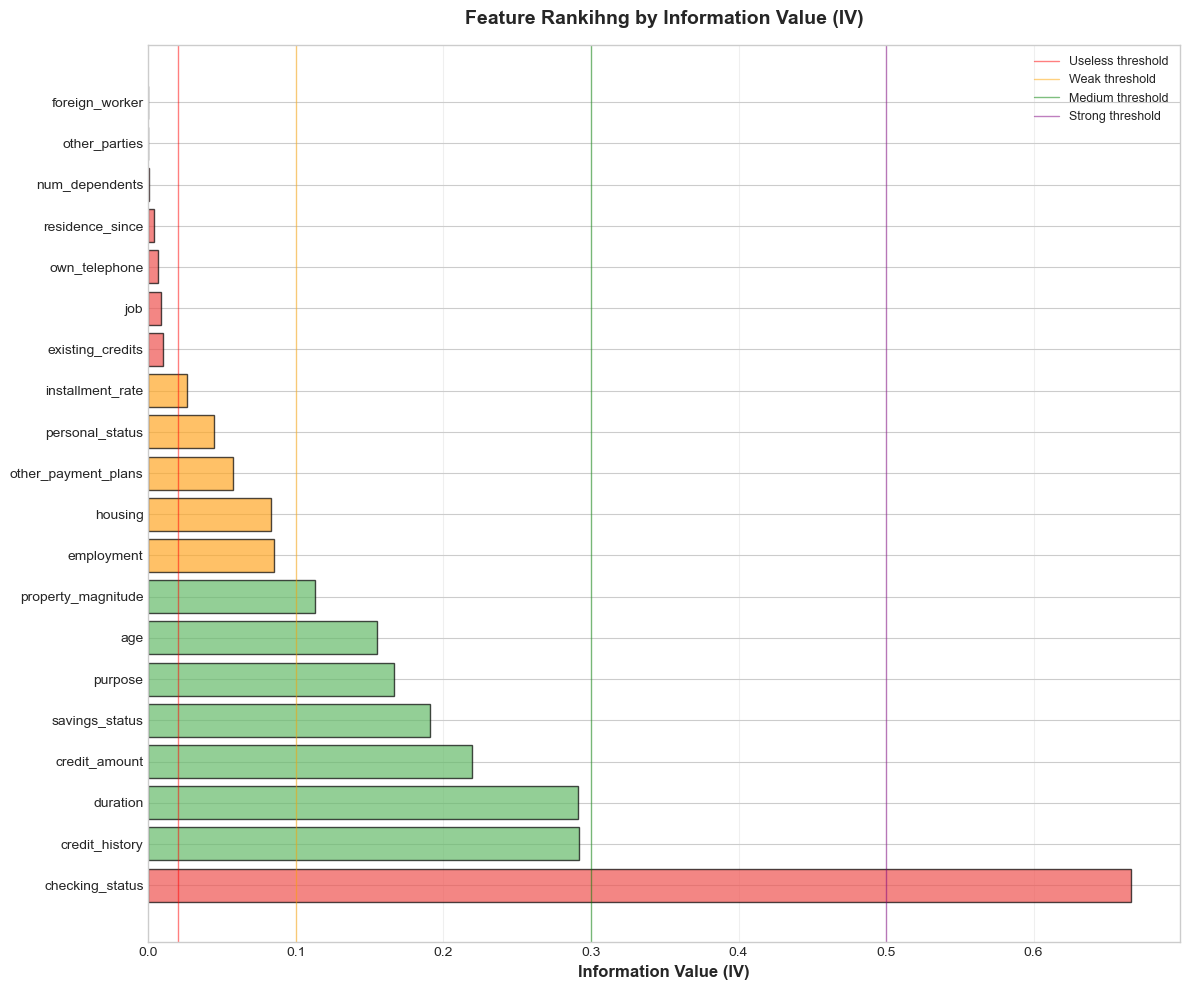

In [7]:
# Visualize IV
plt.figure(figsize=(12,10))

# Color code by predictive power
colors = []
for power in iv_df['Predictive_Power']:
    if power == 'Strong':
        colors.append('#2E7D32')  # Dark green
    elif power == 'Medium':
        colors.append('#66BB6A')  # Light green
    elif power == 'Weak':
        colors.append('#FFA726')  # Orange
    else:
        colors.append('#EF5350')  # Red

plt.barh(range(len(iv_df)),iv_df['IV'], color= colors, alpha =0.7, edgecolor='black')
plt.yticks(range(len(iv_df)), iv_df['Feature'], fontsize =10)
plt.xlabel('Information Value (IV)', fontsize =12, fontweight ='bold')
plt.title('Feature Rankihng by Information Value (IV)', fontsize =14, fontweight ='bold', pad =15)

# Add threshold lines
plt.axvline(x= 0.02, color ='red', linestyle ='-', linewidth =1, alpha =0.5, label ='Useless threshold')
plt.axvline(x=0.10, color='orange', linestyle='-', linewidth=1, alpha=0.5, label='Weak threshold')
plt.axvline(x=0.30, color='green', linestyle='-', linewidth=1, alpha=0.5, label='Medium threshold')
plt.axvline(x=0.50, color='purple', linestyle='-', linewidth=1, alpha=0.5, label='Strong threshold')

plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Step 2.3: Dtailed WOE Analysis for Top Features

### 1. Code Overview
This script iterates through the top 5 features ranked by **Information Value (IV)**. For each feature, it:
* **Displays the WOE Table:** Shows the distribution of good/bad loans and calculated WOE/IV for each bin.
* **Identifies Risk Extremes:** Highlights the bins with the lowest risk (Max WOE) and highest risk (Min WOE).
* **Verifies Monotonicity:** Checks if the WOE values strictly increase or decrease across bins.

### 2. Why is Monotonicity Important?
Monotonicity (a trend that strictly increases or decreases) is a critical quality check for binning in credit scoring.

* **Explainability & Business Logic:**
    * Model behavior must align with domain knowledge. For example, as *Income* increases, *Default Risk* should strictly decrease. A "zigzag" pattern suggests the binning captures noise rather than a signal.
* **Robustness & Overfitting:**
    * Non-monotonic bins often reflect specific quirks in the training data (noise). Enforcing monotonicity through **Coarse Classing** (merging bins) makes the model more robust to unseen data.
* **Linearity Assumption:**
    * Logistic Regression assumes a linear relationship between the predictor variables and the **log-odds** of the target. Monotonic WOE transformations ensure this linearity is preserved.

> **Note:** If `Monotonicity: ✗ No` appears, consider merging adjacent bins to smooth out the trend.

In [8]:
# Analyze top 5 features

top_features = iv_df.head(5)['Feature'].tolist()

for i, feature in enumerate(top_features, 1):
    print(f'Feature {i}: {feature}')

    # Get WOE table for this feature
    woe_table = bins[feature]

    if woe_table is not None:
        print(f'Information Value: {woe_table["total_iv"].iloc[0]:.4f}')
        print(f'WOE Table:')

        # Display relevant columns
        display_cols = ['bin', 'count', 'count_distr', 'good', 'bad', 
                       'badprob', 'woe', 'bin_iv']
        
        # Only show columns that exist
        available_cols = [col for col in display_cols if col in woe_table.columns]
        print(woe_table[available_cols].to_string(index = False))

        max_woe = woe_table['woe'].max()
        min_woe = woe_table['woe'].min()
        max_woe_bin = woe_table.loc[woe_table['woe'].idxmax(), 'bin']
        min_woe_bin = woe_table.loc[woe_table['woe'].idxmin(), 'bin']
        print(f' Max WOE: {max_woe:.4f} (Bin: {max_woe_bin})')
        print(f' Min WOE: {min_woe:.4f} (Bin: {min_woe_bin})')

        # Check monotonicity
        woe_values = woe_table['woe'].values
        is_increasing = all(woe_values[i] <= woe_values[i+1] for i in range(len(woe_values)-1))
        is_decreasing = all(woe_values[i] >= woe_values[i+1] for i in range(len(woe_values)-1))
        is_monotonic = is_increasing or is_decreasing

        if is_monotonic:
            print(' WOE is monotonic.')
        else:
            print(' WOE is not monotonic.')
        print('\n' + '-'*50 + '\n')
        

Feature 1: checking_status
Information Value: 0.6660
WOE Table:
                bin  count  count_distr  good  bad  badprob       woe   bin_iv
No checking account    394        0.394   348   46 0.116751 -1.176263 0.404410
          >= 200 DM     63        0.063    49   14 0.222222 -0.405465 0.009461
         0 - 200 DM    269        0.269   164  105 0.390335  0.401392 0.046447
             < 0 DM    274        0.274   139  135 0.492701  0.818099 0.205693
 Max WOE: 0.8181 (Bin: < 0 DM)
 Min WOE: -1.1763 (Bin: No checking account)
 WOE is monotonic.

--------------------------------------------------

Feature 2: credit_history
Information Value: 0.2918
WOE Table:
                                       bin  count  count_distr  good  bad  badprob       woe   bin_iv
                          Critical account    293        0.293   243   50 0.170648 -0.733741 0.132423
                             Delay in past     88        0.088    60   28 0.318182  0.085158 0.000649
                        

### Step 2.4: Visualize WOE Patterns

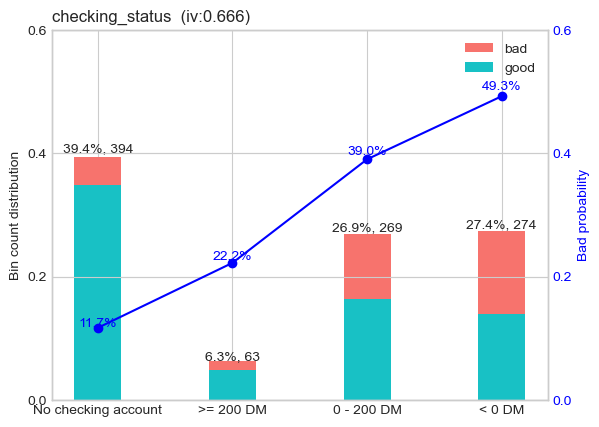

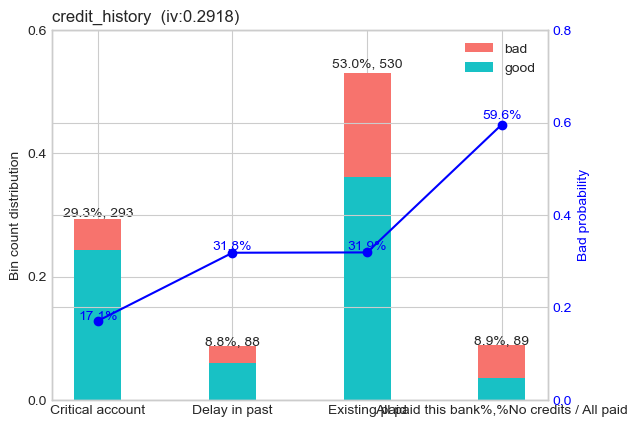

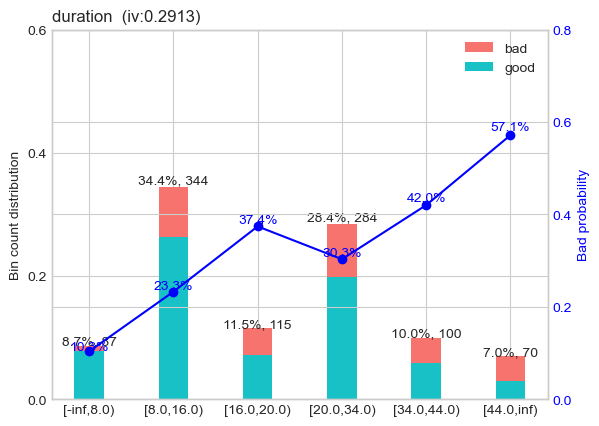

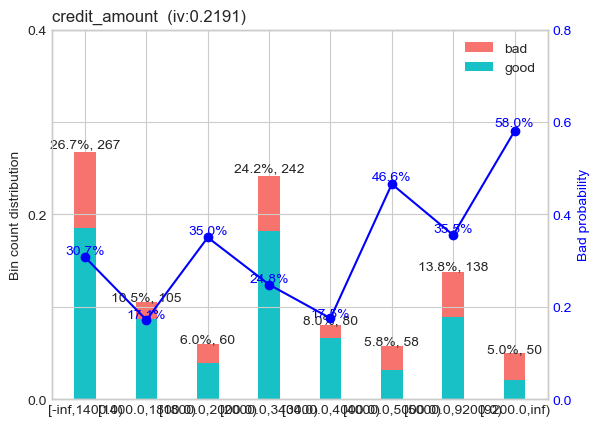

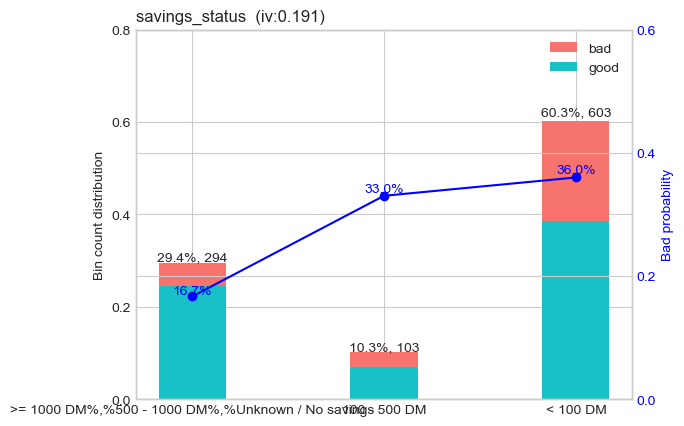

In [9]:
# Create a dictionary with only top features
top_bins = {feat: bins[feat] for feat in top_features}

# Plot WOE
sc.woebin_plot(top_bins)
plt.show()

[INFO] creating woe binning ...


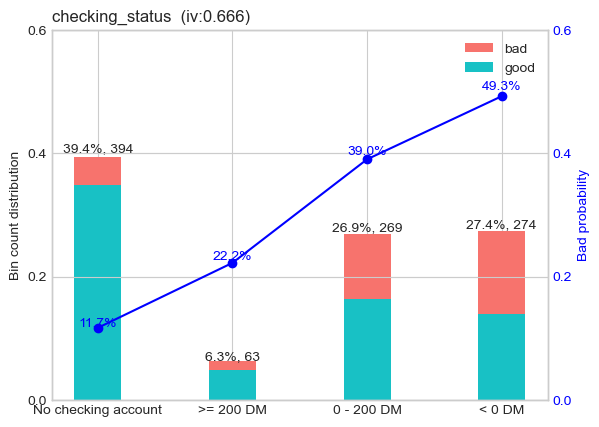

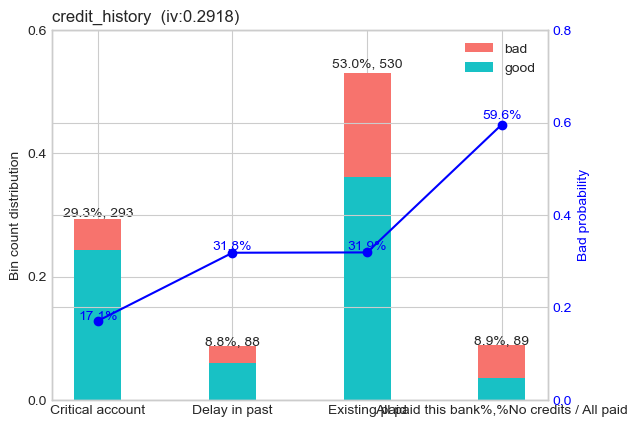

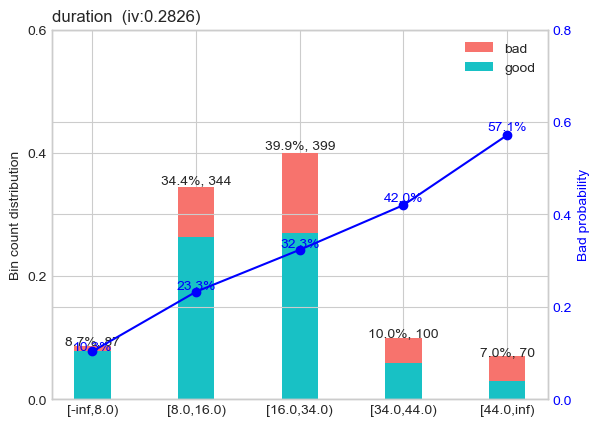

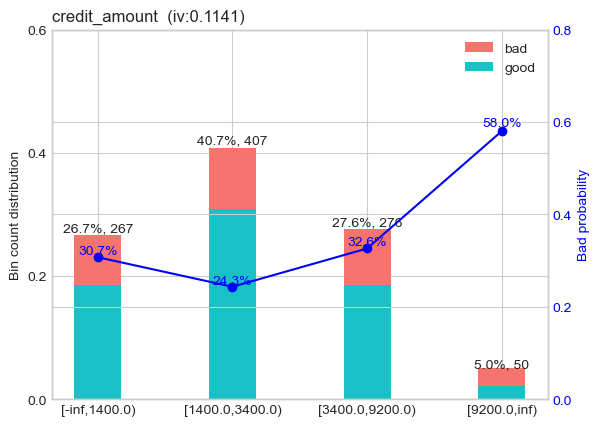

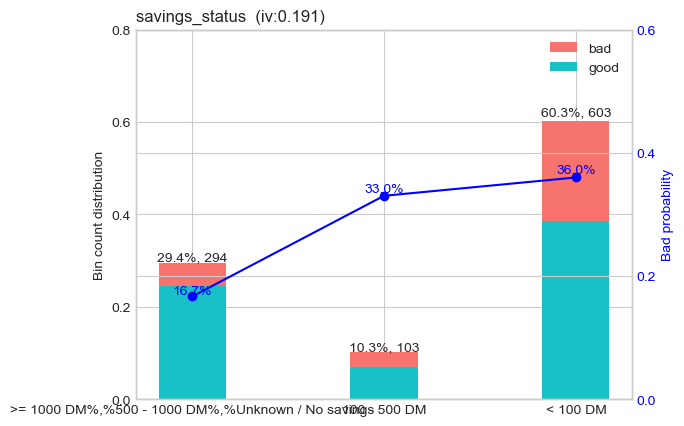

In [10]:
# Duration: Merge [16, 20) and [20, 34) to fix the zigzag pattern -> Remove 20 from breaks
# New breaks: [8, 16, 34, 44]
# Credit Amount: Merge small intervals to reduce noise and create a stable U-shape
# New breaks: [1400, 3400, 9200]
adj_breaks = {
    'duration': [8, 16, 34, 44],
    'credit_amount': [1400, 3400, 9200]
}

new_bins = sc.woebin(
    df,                
    y='default',      
    x=['duration', 'credit_amount'], 
    breaks_list=adj_breaks 
)

# 3. Update the existing bins dictionary
bins.update(new_bins)
top_bins = {feat: bins[feat] for feat in top_features}

sc.woebin_plot(top_bins)
plt.show()

### Step 2.5: Feature Selection Based on IV

In [11]:
# Selection threshold
iv_threshold = 0.02

# Select features
selected_features = iv_df[(iv_df['IV'] >= iv_threshold) & (iv_df['IV'] <= 0.5)]['Feature'].tolist()
excluded_features = iv_df[(iv_df['IV'] < iv_threshold) | (iv_df['IV'] > 0.5)]['Feature'].tolist()

print(f'Selected features (IV >= {iv_threshold}): {selected_features}')
print(f'Excluded features (IV < {iv_threshold}): {excluded_features}')

# Filter bins to only selected features
selected_bins = {feat: bins[feat] for feat in selected_features if feat in bins}

Selected features (IV >= 0.02): ['credit_history', 'duration', 'credit_amount', 'savings_status', 'purpose', 'age', 'property_magnitude', 'employment', 'housing', 'other_payment_plans', 'personal_status', 'installment_rate']
Excluded features (IV < 0.02): ['checking_status', 'existing_credits', 'job', 'own_telephone', 'residence_since', 'num_dependents', 'other_parties', 'foreign_worker']


## Part 3: WOE Transformation using scorecardpy

In [12]:
# Apply WOE transformation
# This replaces original values with WOE values

data_woe = sc.woebin_ply(df, selected_bins)

print(df[selected_features].head(3))

print('After WOE transformation:')
woe_cols = [col for col in data_woe.columns if col.endswith('_woe')]
print(data_woe[woe_cols].head(3))

[INFO] converting into woe values ...
     credit_history  duration  credit_amount        savings_status    purpose  \
0  Critical account         6           1169  Unknown / No savings   Radio/TV   
1     Existing paid        48           5951              < 100 DM   Radio/TV   
2  Critical account        12           2096              < 100 DM  Education   

   age property_magnitude   employment housing other_payment_plans  \
0   67        Real estate   >= 7 years     Own                 NaN   
1   22        Real estate  1 - 4 years     Own                 NaN   
2   49        Real estate  4 - 7 years     Own                 NaN   

                       personal_status  installment_rate  
0                        Male : Single                 4  
1  Female : Divorced/Separated/Married                 2  
2                        Male : Single                 2  
After WOE transformation:
   credit_amount_woe  installment_rate_woe  housing_woe  purpose_woe  \
0           0.033661  

## Part 4: Train-Test Split

In [13]:
# Prepare features and target

X_woe = data_woe[woe_cols]
y = data_woe['default']

random_state =42
# Split data: 70% train, 15% validation, 15% test
X_train_woe, X_temp_woe, y_train, y_temp = train_test_split(
    X_woe, y,
    test_size=0.30,   
    random_state=random_state,
    stratify=y
)

X_val_woe, X_test_woe, y_val, y_test = train_test_split(
    X_temp_woe, y_temp,
    test_size=0.50,   
    random_state=random_state,
    stratify=y_temp
)

total_rows = len(X_woe)
print(f"Total samples: {total_rows}")
print(f" - Train set:      {X_train_woe.shape[0]} samples ({X_train_woe.shape[0]/total_rows:.1%})")
print(f" - Validation set: {X_val_woe.shape[0]} samples ({X_val_woe.shape[0]/total_rows:.1%})")
print(f" - Test set:       {X_test_woe.shape[0]} samples ({X_test_woe.shape[0]/total_rows:.1%})")

Total samples: 1000
 - Train set:      700 samples (70.0%)
 - Validation set: 150 samples (15.0%)
 - Test set:       150 samples (15.0%)


## Part 5: Building Models with WOE Features

### Model 1: Logistic Regression

In [14]:
# Using Optuna to optimize Logistic Regression hyperparameters 
def objective(trial):
    c_candidate = trial.suggest_float('C', 0.01, 10.0, log =True )

    # Model
    model = LogisticRegression(
        C = c_candidate,
        random_state =42,
        max_iter =1000,
        class_weight ='balanced',
        solver ='lbfgs'
    )
    # Train
    model.fit(X_train_woe, y_train)
    # Validate
    val_prob = model.predict_proba(X_val_woe)[:, 1]
    val_auc = roc_auc_score(y_val, val_prob)
    return val_auc

# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f'Best Parameters: {study.best_params}')


[I 2025-12-26 06:40:50,577] A new study created in memory with name: no-name-2d524ff8-4a0c-4638-8633-f5649fdb272e
[I 2025-12-26 06:40:50,587] Trial 0 finished with value: 0.7604232804232804 and parameters: {'C': 0.08628758670202719}. Best is trial 0 with value: 0.7604232804232804.
[I 2025-12-26 06:40:50,599] Trial 1 finished with value: 0.7631746031746032 and parameters: {'C': 0.19395581627972702}. Best is trial 1 with value: 0.7631746031746032.
[I 2025-12-26 06:40:50,607] Trial 2 finished with value: 0.7606349206349206 and parameters: {'C': 0.7756864679619435}. Best is trial 1 with value: 0.7631746031746032.
[I 2025-12-26 06:40:50,616] Trial 3 finished with value: 0.7631746031746032 and parameters: {'C': 3.5339853601746776}. Best is trial 1 with value: 0.7631746031746032.
[I 2025-12-26 06:40:50,624] Trial 4 finished with value: 0.7631746031746033 and parameters: {'C': 1.353505530098092}. Best is trial 4 with value: 0.7631746031746033.
[I 2025-12-26 06:40:50,632] Trial 5 finished with 

Best Parameters: {'C': 1.304231714368835}


In [15]:
best_params = study.best_params

final_lr_model = LogisticRegression(
    C=best_params['C'],
    random_state= random_state,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

final_lr_model.fit(
    X_train_woe, y_train
)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.304231714368835
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
coef_df = pd.DataFrame({
    'Feature': [col.replace('_woe', '') for col in woe_cols],
    'Coefficient': final_lr_model.coef_[0],
    'Abs_Coefficient': np.abs(final_lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

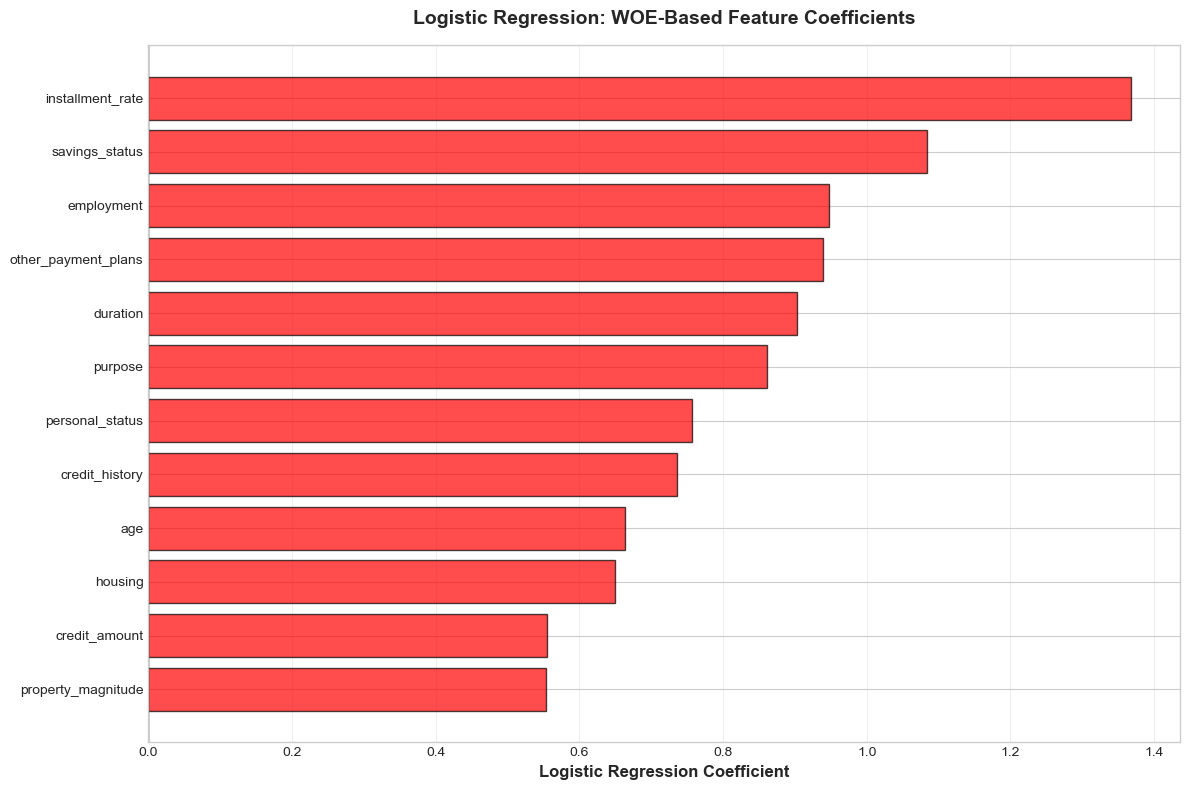

In [17]:
# Visualize coefficients
plt.figure(figsize =(12,8))

coef_sorted = coef_df.sort_values('Coefficient')
colors = ['red' if x>0 else 'blue' for x in coef_sorted['Coefficient']]

plt.barh(range(len(coef_sorted)), coef_sorted['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(coef_sorted)), coef_sorted['Feature'], fontsize=10)
plt.xlabel('Logistic Regression Coefficient', fontsize=12, fontweight='bold')
plt.title('Logistic Regression: WOE-Based Feature Coefficients', 
          fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### Model 2: XGBoost

In [18]:
# Using Optuna to optimize XGBoost hyperparameters
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


def objective(trial):
    params ={
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log =True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        # Fixed values
        'scale_pos_weight': scale_pos_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'use_label_encoder': False,
        'early_stopping_rounds': 50,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**params)

    model.fit(
        X_train_woe, y_train,
        eval_set= [(X_val_woe, y_val)],
        verbose =False
    )
    return model.best_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) 

print(f"Best AUC: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")

[I 2025-12-26 06:40:50,887] A new study created in memory with name: no-name-55095c57-aa1e-45d0-887c-b49e505deb10
[I 2025-12-26 06:40:51,088] Trial 0 finished with value: 0.6915343915343916 and parameters: {'n_estimators': 157, 'max_depth': 7, 'learning_rate': 0.06594877183114457, 'subsample': 0.7455588342977536}. Best is trial 0 with value: 0.6915343915343916.
[I 2025-12-26 06:40:51,136] Trial 1 finished with value: 0.6736507936507936 and parameters: {'n_estimators': 221, 'max_depth': 6, 'learning_rate': 0.08274283543626888, 'subsample': 0.9574963841317516}. Best is trial 0 with value: 0.6915343915343916.
[I 2025-12-26 06:40:51,225] Trial 2 finished with value: 0.6996825396825397 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.017280924871041808, 'subsample': 0.9935300588984978}. Best is trial 2 with value: 0.6996825396825397.
[I 2025-12-26 06:40:51,268] Trial 3 finished with value: 0.6932275132275132 and parameters: {'n_estimators': 215, 'max_depth': 3, 'lear

Best AUC: 0.7007
Best Params: {'n_estimators': 103, 'max_depth': 9, 'learning_rate': 0.05756513990192974, 'subsample': 0.7549785068101934}


In [19]:
best_params = study.best_params

final_xgb_model = xgb.XGBClassifier(**best_params)

final_xgb_model.fit(
    X_train_woe, y_train,
    eval_set=[(X_test_woe, y_test)],
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
feature_importance_xgb = pd.DataFrame({
    'Feature': [col.replace('_woe', '') for col in woe_cols],
    'Importance': final_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

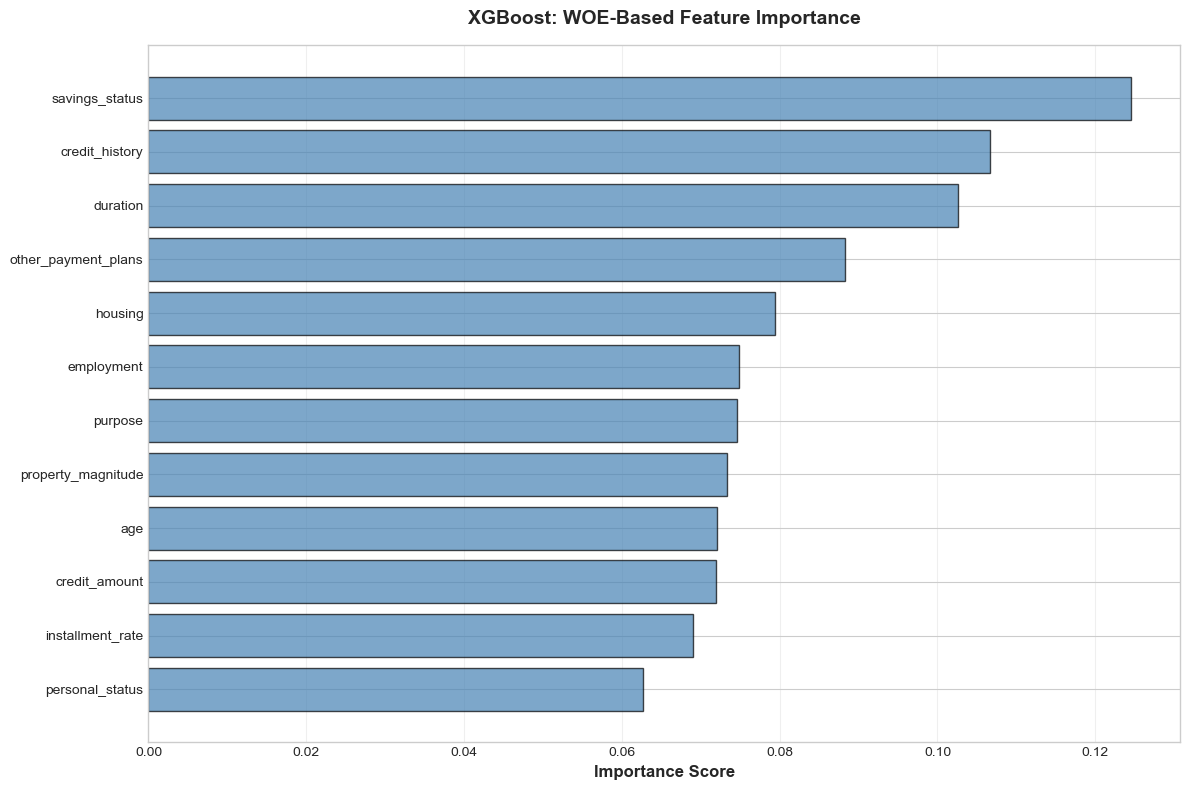

In [21]:
# Visualize
plt.figure(figsize=(12, 8))

importance_sorted = feature_importance_xgb.sort_values('Importance')

plt.barh(range(len(importance_sorted)), importance_sorted['Importance'],
         color='steelblue', alpha=0.7, edgecolor='black')
plt.yticks(range(len(importance_sorted)), importance_sorted['Feature'], fontsize=10)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('XGBoost: WOE-Based Feature Importance', 
          fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Part 6: Model Evaluation

In [22]:
# Prediction
y_train_pred_lr = final_lr_model.predict_proba(X_train_woe)[:, 1]
y_val_pred_lr = final_lr_model.predict_proba(X_val_woe)[:, 1]
y_test_pred_lr = final_lr_model.predict_proba(X_test_woe)[:, 1]

y_train_pred_xgb = final_xgb_model.predict_proba(X_train_woe)[:, 1]
y_val_pred_xgb = final_xgb_model.predict_proba(X_val_woe)[:, 1]
y_test_pred_xgb = final_xgb_model.predict_proba(X_test_woe)[:, 1]

In [23]:
# Calculate AUC

train_auc_lr = roc_auc_score(y_train, y_train_pred_lr)
val_auc_lr = roc_auc_score(y_val, y_val_pred_lr)
test_auc_lr = roc_auc_score(y_test, y_test_pred_lr)

train_auc_xgb = roc_auc_score(y_train, y_train_pred_xgb)
val_auc_xgb = roc_auc_score(y_val, y_val_pred_xgb)
test_auc_xgb = roc_auc_score(y_test, y_test_pred_xgb)

print('Logistic Regression AUC:')
print(f' - Train AUC: {train_auc_lr:.4f}')
print(f' - Validation AUC: {val_auc_lr:.4f}')
print(f' - Test AUC: {test_auc_lr:.4f}\n')
print(f' - Overfit: {train_auc_lr - val_auc_lr:.4f}')

print('XGBoost AUC:')
print(f' - Train AUC: {train_auc_xgb:.4f}')
print(f' - Validation AUC: {val_auc_xgb:.4f}')
print(f' - Test AUC: {test_auc_xgb:.4f}\n')
print(f' - Overfit: {train_auc_xgb - val_auc_xgb:.4f}')

print('Comparison of AUC Scores:')
print(f'XGBoost advantage: {(test_auc_xgb - test_auc_lr):.4f}')


Logistic Regression AUC:
 - Train AUC: 0.7965
 - Validation AUC: 0.7634
 - Test AUC: 0.8063

 - Overfit: 0.0331
XGBoost AUC:
 - Train AUC: 0.9958
 - Validation AUC: 0.6648
 - Test AUC: 0.7460

 - Overfit: 0.3310
Comparison of AUC Scores:
XGBoost advantage: -0.0603


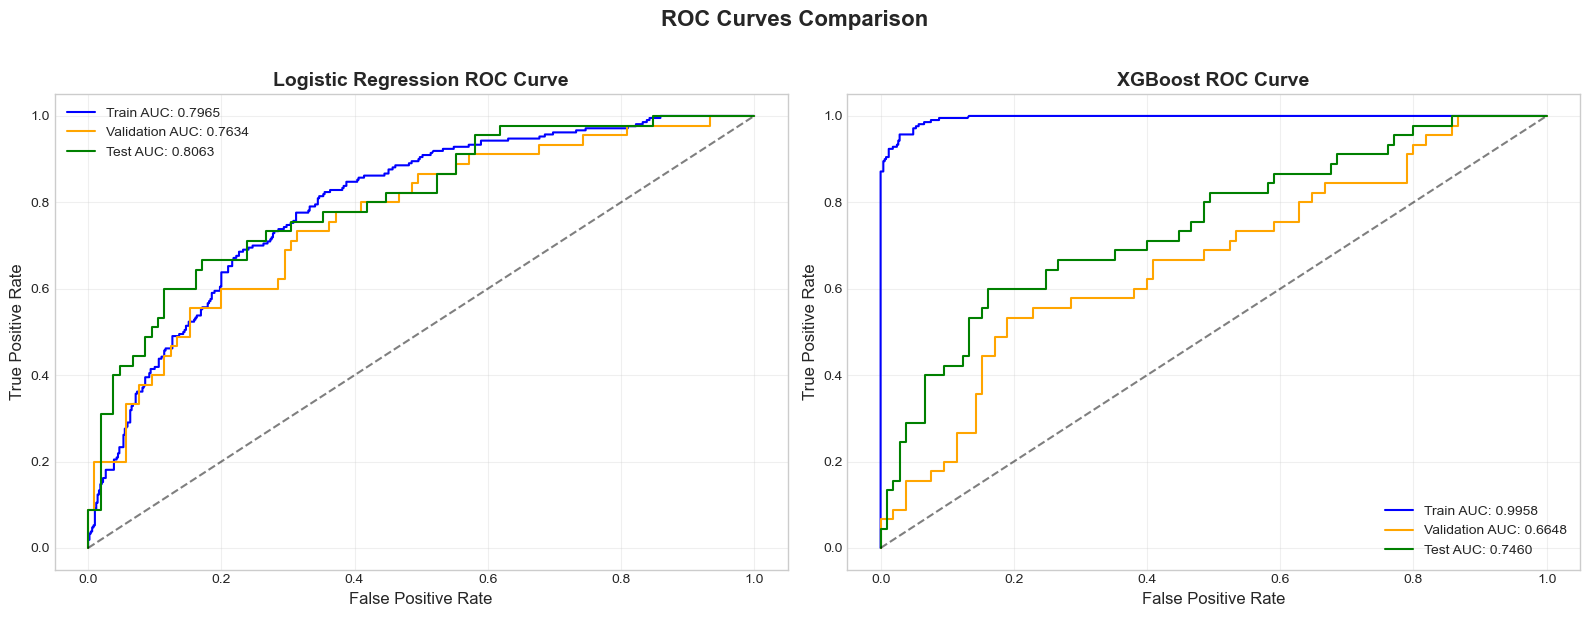

In [24]:
# Plot ROC Curves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16, 6))

# Logistic Regression

fpr_train_lr, tpr_lr_train, _ = roc_curve(y_train, y_train_pred_lr)
fpr_val_lr, tpr_lr_val, _ = roc_curve(y_val, y_val_pred_lr)
fpr_test_lr, tpr_lr_test, _ = roc_curve(y_test, y_test_pred_lr)
ax1.plot(fpr_train_lr, tpr_lr_train, label=f'Train AUC: {train_auc_lr:.4f}', color='blue')
ax1.plot(fpr_val_lr, tpr_lr_val, label=f'Validation AUC: {val_auc_lr:.4f}', color='orange')
ax1.plot(fpr_test_lr, tpr_lr_test, label=f'Test AUC: {test_auc_lr:.4f}', color='green')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title('Logistic Regression ROC Curve', fontsize=14, fontweight='bold')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

#XGBoost
fpr_train_xgb, tpr_xgb_train, _ = roc_curve(y_train, y_train_pred_xgb)
fpr_val_xgb, tpr_xgb_val, _ = roc_curve(y_val, y_val_pred_xgb)
fpr_test_xgb, tpr_xgb_test, _ = roc_curve(y_test, y_test_pred_xgb)
ax2.plot(fpr_train_xgb, tpr_xgb_train, label=f'Train AUC: {train_auc_xgb:.4f}', color='blue')
ax2.plot(fpr_val_xgb, tpr_xgb_val, label=f'Validation AUC: {val_auc_xgb:.4f}', color='orange')
ax2.plot(fpr_test_xgb, tpr_xgb_test, label=f'Test AUC: {test_auc_xgb:.4f}', color='green')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_title('XGBoost ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('ROC Curves Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [25]:
# KS Statistic

def ks_statistic(y_true, y_pred):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df = df.sort_values('y_pred', ascending =False).reset_index(drop =True)
    
    df['cumsum_bad'] = df['y_true'].cumsum()/ df['y_true'].sum()
    df['cumsum_good'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()

    df['ks'] = df['cumsum_bad'] - df['cumsum_good']
    ks_value = df['ks'].max()

    return ks_value

ks_lr = ks_statistic(y_test, y_test_pred_lr)
ks_xgb = ks_statistic(y_test, y_test_pred_xgb)

print(f'Logistic Regression KS Statistic: {ks_lr:.4f}')
print(f'XGBoost KS Statistic: {ks_xgb:.4f}')

Logistic Regression KS Statistic: 0.4952
XGBoost KS Statistic: 0.4381


## Part 7: scorecardpy Performance Report

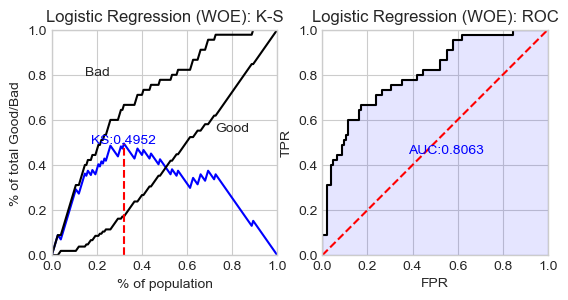

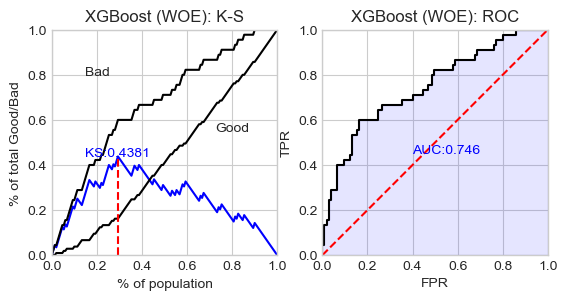

In [26]:
# Generate performance report

pred_df = pd.DataFrame({
    'label': y_test,            
    'pred_lr': y_test_pred_lr,   
    'pred_xgb': y_test_pred_xgb  
})

# 1. Logistic Regression
perf_lr = sc.perf_eva(
    label=pred_df['label'],    
    pred=pred_df['pred_lr'],    
    title='Logistic Regression (WOE)',
    show_plot=['ks', 'roc']
)

# 2. XGBoost
perf_xgb = sc.perf_eva(
    label=pred_df['label'],     
    pred=pred_df['pred_xgb'], 
    title='XGBoost (WOE)',
    show_plot=['ks', 'roc']
)

plt.show()

## Part 8: Scorecard generation

While XGBoost demonstrated competitive performance, we selected Logistic Regression as our final model due to its superior interpretability, which is a critical requirement in credit risk management.

We will now utilize ``scorecardpy`` to transform the model results into a standardized credit scorecard (similar to FICO). The scoring scale is calibrated such that a borrower with a 5% probability of default receives a Base Score of 600 points.

In [27]:
# --- Scorecard Generation ---
# points0: Target score (e.g., 600 points)
# odds0: Target odds at points0 (e.g., 1:19 means approx 5% default rate)
# pdo: Points to Double the Odds (e.g., score decreases by 50 when odds double)
x_columns = list(X_train_woe.columns)
card = sc.scorecard(bins, final_lr_model, x_columns, points0=600, odds0=1/19, pdo=50)

# Convert the dictionary to a DataFrame for easier viewing
scorecard_df = pd.concat(card, ignore_index=True)

# Display the top 10 rows of the scorecard
# This table can be exported to Excel for loan officers
print("--- Final Scorecard Table ---")
print(scorecard_df.head(10))

--- Final Scorecard Table ---
           variable              bin  points
0        basepoints              NaN   387.0
1     credit_amount    [-inf,1400.0)    -1.0
2     credit_amount  [1400.0,3400.0)    12.0
3     credit_amount  [3400.0,9200.0)    -5.0
4     credit_amount     [9200.0,inf)   -47.0
5  installment_rate       [-inf,2.0)    25.0
6  installment_rate        [2.0,3.0)    15.0
7  installment_rate        [3.0,4.0)     6.0
8  installment_rate        [4.0,inf)   -16.0
9           housing              Own     9.0


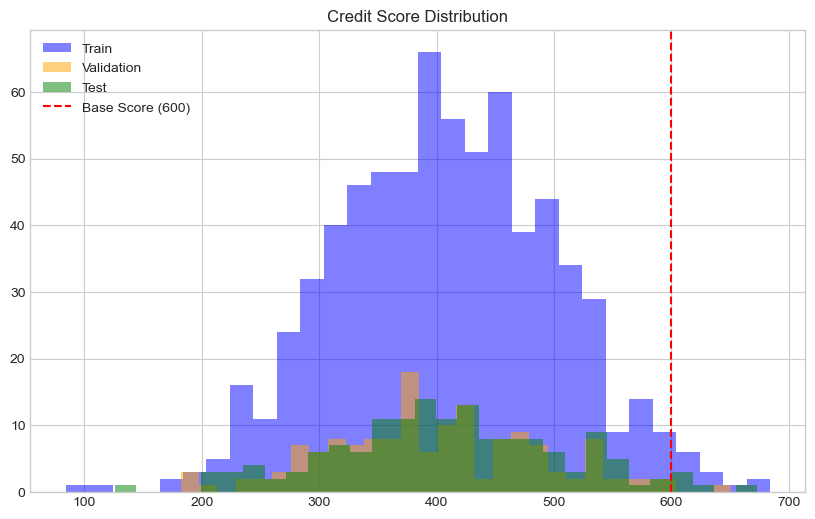

            score
count  700.000000
mean   407.375714
std     92.624816
min     84.000000
25%    340.000000
50%    407.000000
75%    469.000000
max    684.000000


In [28]:
train_real = df.loc[X_train_woe.index]
val_real = df.loc[X_val_woe.index]
test_real = df.loc[X_test_woe.index]

x_columns = list(X_train_woe.columns)
card = sc.scorecard(bins, final_lr_model, x_columns, points0=600, odds0=1/19, pdo=50)

train_score = sc.scorecard_ply(train_real, card, print_step=0)
val_score = sc.scorecard_ply(val_real, card, print_step=0)
test_score = sc.scorecard_ply(test_real, card, print_step=0)


plt.figure(figsize=(10, 6))
plt.hist(train_score, bins=30, alpha=0.5, label='Train', color='blue')
plt.hist(val_score, bins =30, alpha=0.5, label='Validation', color='orange')
plt.hist(test_score, bins=30, alpha=0.5, label='Test', color='green')
plt.axvline(x=600, color='red', linestyle='--', label='Base Score (600)')
plt.title('Credit Score Distribution')
plt.legend()
plt.show()

print(train_score.describe())